In [1]:
## Deconvolution into discrete subpopulations using a general mixture model (GMM)

## Imports and variables

import glob
import os
import sys 
from tqdm import tqdm
from pathlib import Path
import numpy as np

# Path hidpy
sys.path.append('%s/../' % os.getcwd())

from deconvolution import applyGMM_functions
from deconvolution import applyGMMconstrained_fitout_functions
from deconvolution import importDeconvolutionGMM


BayesMat={} # Dictionary with all the Bayes struct per cell
numDist = 3 # Choose maximum number of distributions

pathBayesCells='%s/../output-paper/vals' % os.getcwd()
parameters2decon=['D','A','V']




nbins=20

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


['/ssd1/projects/hidpy/notebooks/../output-paper/vals/Results_Bayes_u2os-h2bgfp-serum-1_100.pickle', '/ssd1/projects/hidpy/notebooks/../output-paper/vals/Results_Bayes_u2os-h2bgfp-serum-2_100.pickle', '/ssd1/projects/hidpy/notebooks/../output-paper/vals/Results_Bayes_u2os-h2bgfp-serum-3_100.pickle']


100%|██████████| 3/3 [00:00<00:00,  9.20it/s]


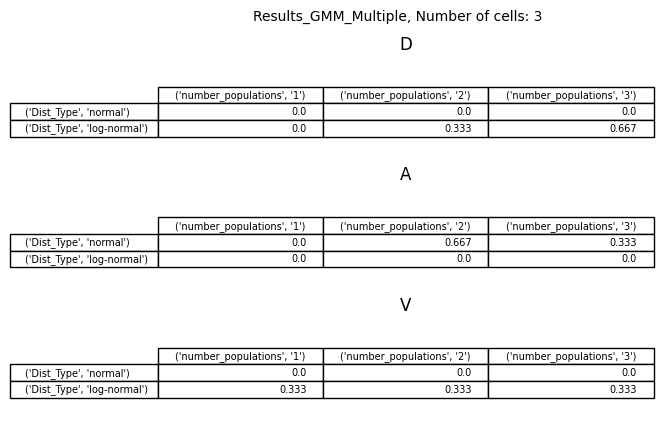

In [2]:
## Deconvolution GMM

listdir=glob.glob(pathBayesCells+'*.pickle')  # Read cell pickle files

import os
files = list()
for file in os.listdir(pathBayesCells):
    if file.endswith(".pickle"):
        files.append(file)

for i in range(len(files)):
    files[i] = '%s/%s' % (pathBayesCells, files[i])

listdir = files
print(files)

BayesMat=importDeconvolutionGMM.applyGMM_Multiple(listdir,parameters2decon,numDist) # Apply GMM

pathBayesCells_GMM_Multiple=pathBayesCells+'/GMM_Multiple/'

try: 
    os.mkdir(pathBayesCells_GMM_Multiple)
except: 
    print('WARNING: The output path [%s] exists' %pathBayesCells_GMM_Multiple)
    [f.unlink() for f in Path(pathBayesCells_GMM_Multiple).glob("*") if f.is_file()] 

importDeconvolutionGMM.generatetable_TestGMM(pathBayesCells_GMM_Multiple,BayesMat,parameters2decon) # Make Table

100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


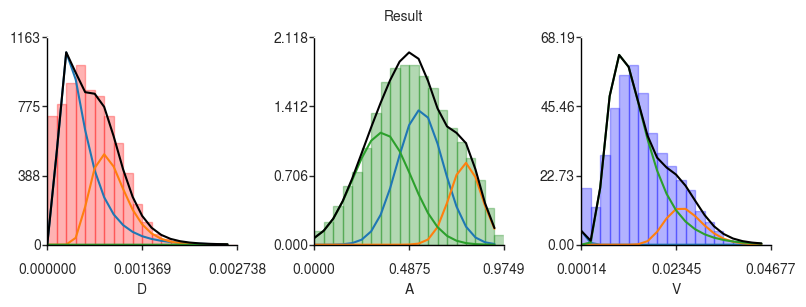

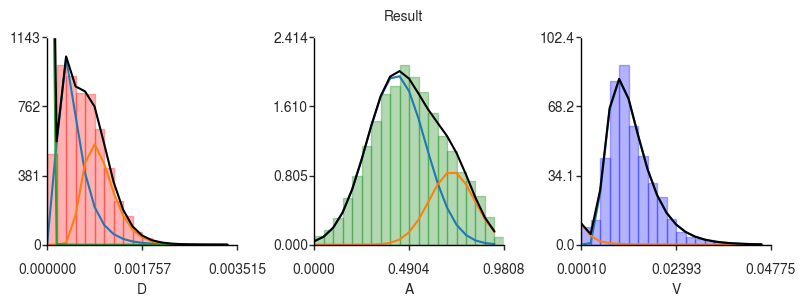

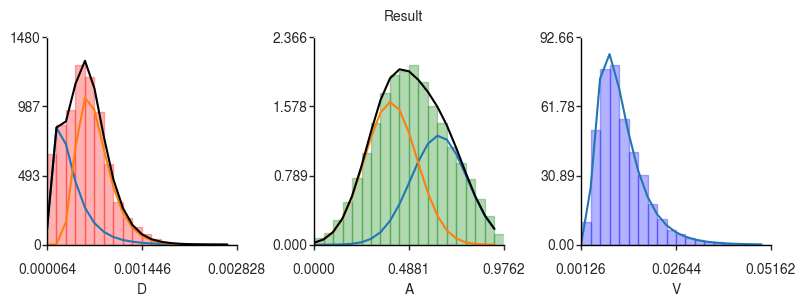

In [3]:
# Generating plots for inspection
from turtle import width


showplots=True

pathBayesCells_Plots=pathBayesCells_GMM_Multiple+'Plots_GMM_Multiple/'

try: 
    os.mkdir(pathBayesCells_Plots)
except: 
    print('WARNING: The output path [%s] exists' %pathBayesCells_Plots)
    [f.unlink() for f in Path(pathBayesCells_Plots).glob("*") if f.is_file()] 

importDeconvolutionGMM.generateplots_TestGMM(pathBayesCells_Plots, BayesMat, parameters2decon, nbins, showplots)

In [169]:
# Run GMM based on table and plots for each parameter [D A V]

Sel_DistributionType=['lognormal','normal','lognormal']
Sel_numDist=[3,2,3]

BayesMatSel=importDeconvolutionGMM.applyGMMconstrained_dir(listdir,parameters2decon,Sel_DistributionType,Sel_numDist)


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Verify Package!


100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


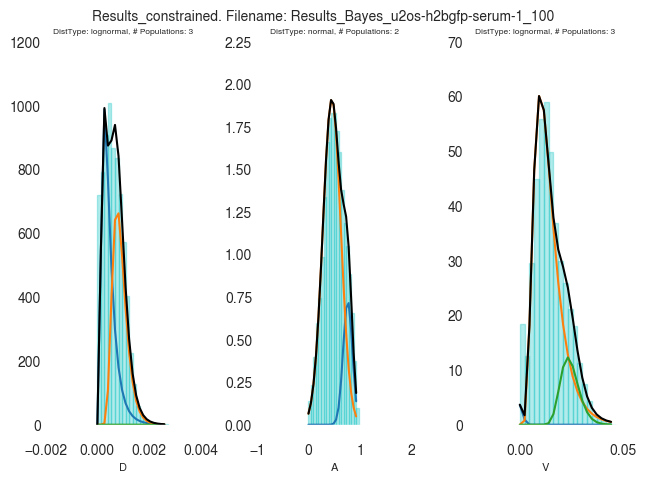

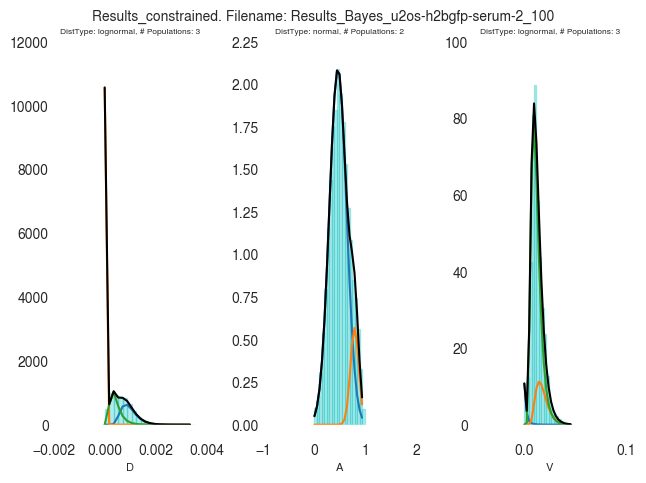

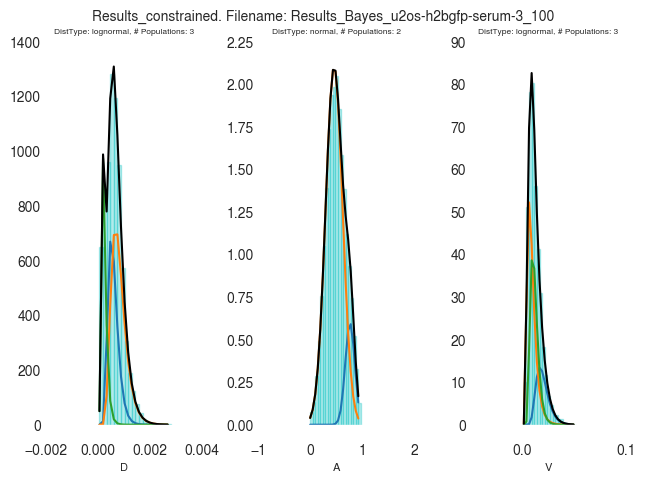

In [170]:
# Generate plots GMM constrained

pathGMMConstrained=pathBayesCells+'/GMM_Constrained/'
try: 
    os.mkdir(pathGMMConstrained)
except: 
    print('WARNING: The output path [%s] exists' %pathGMMConstrained)
    [f.unlink() for f in Path(pathGMMConstrained).glob("*") if f.is_file()]

pathBayesCells_Plots_constrained=pathGMMConstrained+'/Plots_GMM_Constrained/'
showplots=True
try: 
    os.mkdir(pathBayesCells_Plots_constrained)
except: 
    print('WARNING: The output path [%s] exists' %pathBayesCells_Plots_constrained)
    [f.unlink() for f in Path(pathBayesCells_Plots_constrained).glob("*") if f.is_file()]


importDeconvolutionGMM.generateplots_GMMconstrained_fitout(pathBayesCells_Plots_constrained,BayesMatSel,parameters2decon,nbins,Sel_DistributionType,Sel_numDist,showplots)


  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_63220/3785402409.py:113: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar=fig.colorbar(img1, cax=cax, ax=ax,spacing='proportional',orientation='horizontal',boundaries=[-0.5] + bounds[0:numPop+1] + [numPop+0.5])
100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


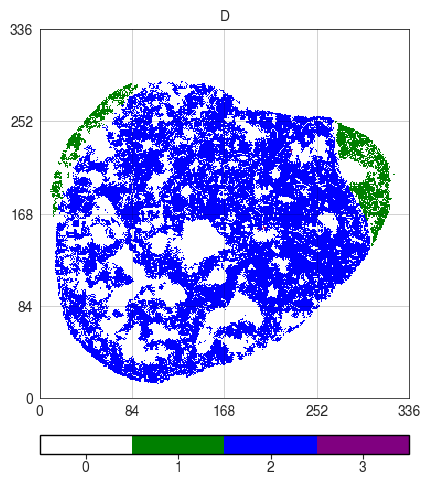

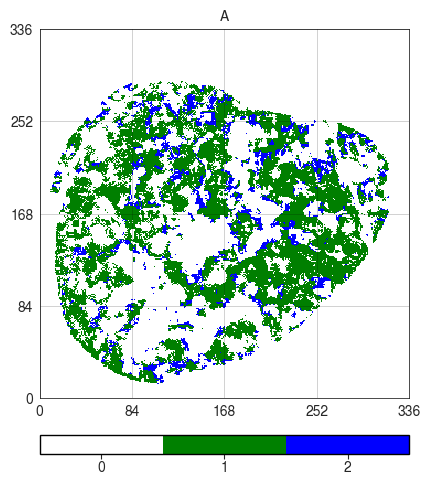

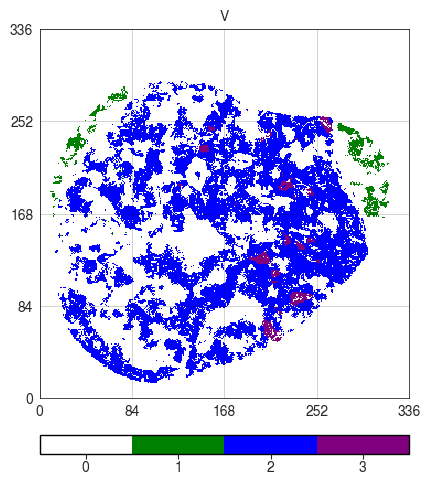

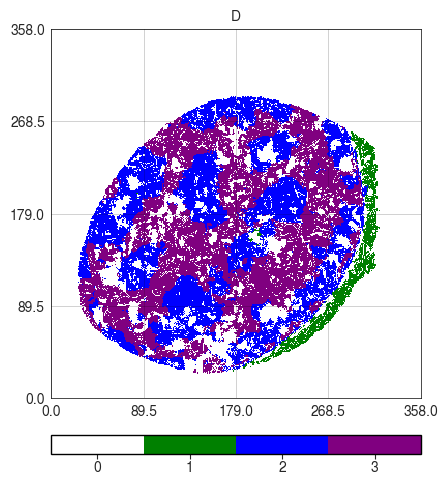

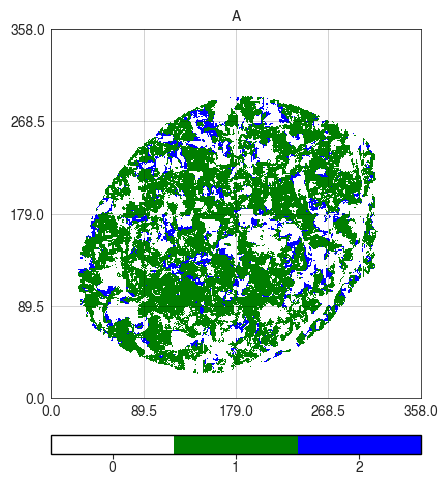

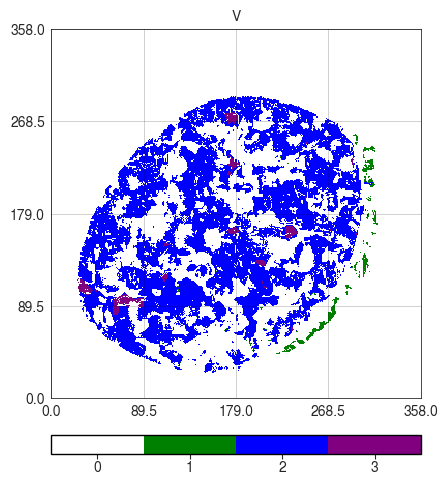

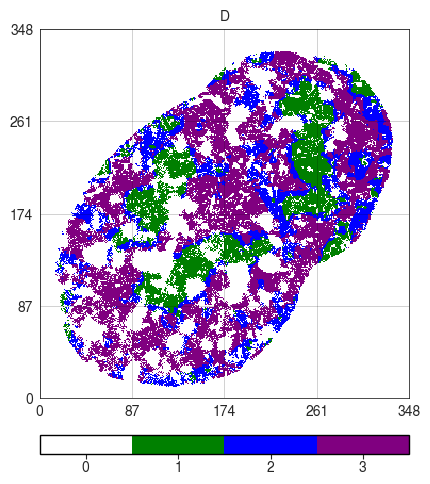

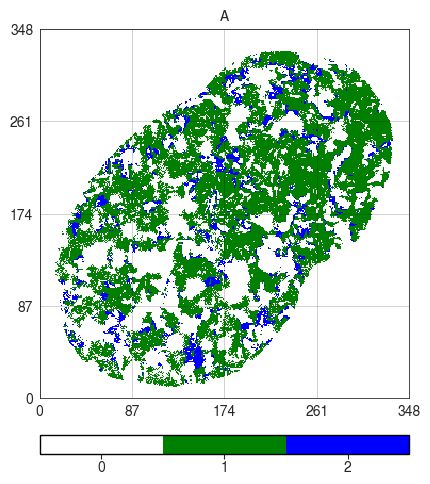

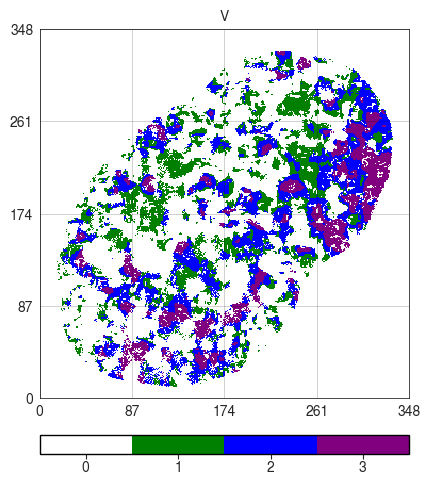

In [171]:
# Generate spatial mapping of population deconvolution

pathBayesCells_Populations_Plots=pathGMMConstrained+'/Populations_Plots_Stats/'
try: 
    os.mkdir(pathBayesCells_Populations_Plots)
except: 
    print('WARNING: The output path [%s] exists' %pathBayesCells_Populations_Plots)
    [f.unlink() for f in Path(pathBayesCells_Populations_Plots).glob("*") if f.is_file()]
    

showplots=True

####################################################################################################
# @sample_range
####################################################################################################
def sample_range(start,
                 end,
                 steps):

    # Delta
    delta = 1. * (end - start) / (steps - 1)

    # Data
    data = list()
    for i in range(steps):
        value = start + i * delta
        data.append(value)

    return data

def generate_plots_stats_decon(BayesMatSel,param,pathBayesCells_Populations_Plots,showplots):

    
    from matplotlib import colors, pyplot
    import seaborn
    font_size = 10
    import numpy
    seaborn.set_style("whitegrid")
    pyplot.rcParams['axes.grid'] = 'True'
    pyplot.rcParams['grid.linewidth'] = 0.5
    pyplot.rcParams['grid.color'] = 'black'
    pyplot.rcParams['grid.alpha'] = 0.25
    pyplot.rcParams['font.family'] = 'NimbusSanL'
    pyplot.rcParams['font.monospace'] = 'Regular'
    pyplot.rcParams['font.style'] = 'normal'
    pyplot.rcParams['axes.labelweight'] = 'light'
    pyplot.rcParams['axes.linewidth'] = 0.5
    pyplot.rcParams['axes.labelsize'] = font_size
    pyplot.rcParams['xtick.labelsize'] = font_size
    pyplot.rcParams['ytick.labelsize'] = font_size
    pyplot.rcParams['legend.fontsize'] = font_size
    pyplot.rcParams['figure.titlesize'] = font_size
    pyplot.rcParams['axes.titlesize'] = font_size
    pyplot.rcParams['xtick.major.pad'] = '1'
    pyplot.rcParams['ytick.major.pad'] = '1'
    pyplot.rcParams['axes.edgecolor'] = '0'
    pyplot.rcParams['axes.autolimit_mode'] = 'round_numbers'
    from matplotlib import colors, pyplot
    import seaborn

    import numpy
    bounds = [0.5, 1.5, 2.5, 3.5, 4.5]

    labels = BayesMatSel['Deconvolution'][param]['labels']
    unique_labels = np.unique(labels)
    thresh = []

    for label in unique_labels:
        data_in_label = BayesMatSel['Deconvolution'][param]['GMM_input'][labels==label]
        thresh.append( np.max(data_in_label))

    thresh = np.sort(thresh)[:-1] # the last entry is not actually a threshold

    # # for debugging - can be commented
    # plt.plot(BayesMatSel[cell_id]['Deconvolution'][param]['x'], \
    #     BayesMatSel[cell_id]['Deconvolution'][param]['p_pop'])
    # for i in range(len(thresh)):
    #     plt.plot((thresh[i], thresh[i]), (0, 1))

    # map distributions back to nucleus
    labels_map = np.zeros(BayesMatSel[param].shape, dtype=int)
    numPop = len(thresh)+1
    for t in range(numPop):
        assigned_label = t+1    
        if t == 0:
            labels_map[BayesMatSel[param]<=thresh[t]] = assigned_label
        elif t > 0 and t<numPop-1:
            labels_map[ np.logical_and(BayesMatSel[param]>thresh[t-1], BayesMatSel[param]<=thresh[t]) ] = assigned_label
        else:
            labels_map[BayesMatSel[param]>thresh[t-1]] = assigned_label
    labels_map[BayesMatSel[param]==0] = 0

    
    #fig,ax=plt.subplots(1,2,figsize=[10,5])
    # Plot 
    fig, ax = pyplot.subplots()
        
    listcolors=['w','g','b','purple','r','greenyellow']
    cmap = colors.ListedColormap(listcolors[0:numPop+1])

    # Create the ticks of the images 
    xticks = sample_range(0, labels_map.shape[0], 5)
    yticks = sample_range(0, labels_map.shape[1], 5)
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    # Color-basr axis 
    cax = ax.inset_axes([0.00, -0.15, 1.0, 0.05])

    img1=ax.imshow(labels_map, interpolation='nearest', cmap=cmap,origin='lower')
    cbar=fig.colorbar(img1, cax=cax, ax=ax,spacing='proportional',orientation='horizontal',boundaries=[-0.5] + bounds[0:numPop+1] + [numPop+0.5])
    cbar.outline.set_color('black')
    cbar.outline.set_linewidth(1)
    labels_cbar = np.arange(0, numPop+1, 1)
    loc = labels_cbar
    cbar.set_ticks(loc)
    ax.set_title(param)

    output_directory='/projects/hidpy/output-paper/u2os-h2bgfp-serum-3/100_ex_ex'
    frame_prefix=param

    # Save the figure 
    pyplot.savefig('%s/%s.png' % (output_directory, frame_prefix), dpi=300, bbox_inches='tight', pad_inches=0)

for i in tqdm(range(len(BayesMatSel))):
    for j in range(len(parameters2decon)):
         
        #importDeconvolutionGMM.generate_plots_stats_decon(BayesMatSel[i],parameters2decon[j],pathBayesCells_Populations_Plots,showplots)
        generate_plots_stats_decon(BayesMatSel[i],parameters2decon[j],pathBayesCells_Populations_Plots,showplots)

        #except:
        #    filename_without_ext = os.path.splitext(BayesMatSel[i]['filename'])[0]
        #    print('WARNING: Error generating population label plot: File: '+filename_without_ext+' Parameter: '+parameters2decon[j])
